# Evaluation 3.8

The goal of this evlauation is to improve on Eval 3.5. 

Network Properties:
- Stateless LSTM architecture
- Multi-batch training (full GPU utilization)
- Input consists of features AND sequential data; batch_size = None, input_size = (sequence_length, num_features)
- Bidirectional LSTM (this is an improvement)
- mutliple batches in each epoch
- fixed bug in 'max' encoding
- try reducing the size of the network to 2 Bidirectional LSTM's. (3 Bidirectional LSTM's means 0.48 seconds for a forward pass, 2 Bidirectional LSTM's takes 0.32 seconds)
- input for each epoch always consists of the complete dataset (uniform probabilities of being chosen)


Implemented in this evaluation:
- CuDNNLSTM replaces LSTM -- improves to 11 ms inference time

Results
- In order to get a reliable ID, one would expect to need about 3 bit sequences. Each sequence is 16 bits long. 3 sequences takes 200 ms. At this point, we would need to process the 3 sequences. This takes about 10 ms. The total at this point is 210 ms.
- We can run this algorithm at 100 FPS. We are getting full bit sequences at 15 FPS. We are getting coordinate data at 240 FPS.

TODO:
- optimize model to make it faster
    - [Pruning](https://www.tensorflow.org/model_optimization/guide/pruning/pruning_with_keras)
    - [Quantization](https://www.tensorflow.org/lite/performance/post_training_quantization#full_integer_quantization_of_weights_and_activations) - May not be possible with LSTMs?
    - Use GPU?
    - Smaller architecture
- Dropout?
- Input is [0,1] instead of [-1,1]? (what would a null input be? What makes the most sense?
- Multi-stage Training:
    - Stage 1: Train without noise (ideal input)
    - Stage 2: Beginning with a pretrained model, continue training with these sources of noise:
        - temporal compression / expansion by 1% (simulating the lamp going out of sync)
        - incorrect bits 3% of the time (should this simulate "bleeding" of "ON" bits into "OFF" bits?)
        - sequence isn't complete (half the time, randomly padded with zeros at beginning up to a point)
        - lamp isn't seen for some time, then becomes seen again (-1 bits fill in this space)
        - XYZ spatial noise += 2 cm

## Include Libraries

In [1]:
# Include all relevant libraries
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import seaborn as sn
import pandas as pd

import unicodedata
import re
import numpy as np
import os
import io
import time
import datetime

import random
import copy
import math
import Quaternion as quat
import cProfile
# import mathutils
from numpy import cross, eye, dot
from scipy.linalg import expm, norm
from matplotlib import animation, rc
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML
import pickle

In [2]:
tf.config.experimental.list_physical_devices('GPU')

# from keras import backend as K
# K.tensorflow_backend._get_available_gpus()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Include Methods

In [3]:
def getBits(value, nBits, endianType="little"): 
  return np.array([((value & (1 << i)) >> i) for i in range(nBits)])[::(int(endianType=="little")*2-1)]

# Get ID based on bits and endianness
def getID(bits, endianType="little"): 
  return np.sum(np.power(2, np.nonzero(np.squeeze(np.array(bits))[::(int(endianType=="little")*2-1)])))

def normalizeID(ID, nBits):
  # Normalize between -1 and 1
  return ID / pow(2,nBits) * 2.0 - 1.0

# series of bits with a stop bit at the beginning
def getBaseSequence(ID, nBits, endianType="little", bIncludeStop=True):
  out = getBits(ID, nBits, endianType)
  if bIncludeStop:
    out = np.insert(out, 0, -1)
  return out

def getPulseLengthEncoding(sequence, pulseStartBit = 0, offLength = 1, onLength = 2, stopLength = 5):
  a = pulseStartBit
  b = 1 - a
  return np.hstack(np.array([np.array([a]+[b]*((i==-1)*stopLength+(i==0)*offLength+(i==1)*onLength)) for i in sequence]))

def getSwitchEncoding(sequence, startBit = 1, stopLength = 3):
  a = startBit
  b = 1 - a
  return np.hstack(np.array([np.array([a]+[(a*(i==1)+b*(i<=0))]*((i!=-1)*1+(i==-1)*stopLength)) for i in sequence]))

def getNonEncodedSequence(sequence):
  return sequence

def isMaxEncodingPossible(sequence, nMaxZeros=2):
    seq = np.delete(sequence, np.where(sequence == -1))
    maxZeroSeq = ''.join('0' for x in range(nMaxZeros+1))
    bitString =''.join(str(abs(x)) for x in seq)
    return maxZeroSeq not in bitString

def getMaxEncodedSequence(sequence, nMaxZeros=2, stopLength=3):
    if not isMaxEncodingPossible(sequence, nMaxZeros): return None
#     return np.hstack(np.array([[i*(i>=0)+0*(i<0)]*(1*(i>=0)+stopLength*(i<0)) for i in sequence]))
    stop = [1]+[0]*stopLength+[1]
    out = []
    for i in sequence:
        if i >= 0: out.append(i)
        else: out.append(stop)
    return np.hstack(np.array(out))

def getRandomMaxEncoding(nBits, nMaxZeros=2, stopLength=3):
    out = []
    for i in range(nBits):
        if i == 0 or out[-1] == 1:
            out.append(np.random.randint(2))
        elif np.sum(out[max(len(out)-nMaxZeros,0):len(out)])==0:
            out.append(1)
        else:
            out.append(np.random.randint(2))
    out.append([1]+[0]*stopLength+[1])
    return np.hstack(np.array(out))

def getRandomMaxEncodingID(nBits, nMaxZeros=2, stopLength=3):
    out = []
    for i in range(nBits):
        if i == 0 or out[-1] == 1:
            out.append(np.random.randint(2))
        elif np.sum(out[max(len(out)-nMaxZeros,0):len(out)])==0:
            out.append(1)
        else:
            out.append(np.random.randint(2))
    out = np.hstack(np.array(out))
    return getID(out)

def getAllPossibleMaxIDs(nBits, nMaxZeros=2):
    out = []
    for i in range(pow(2, nBits)):
        seq = getBaseSequence(i, nBits)
        if isMaxEncodingPossible(seq, nMaxZeros):
            out.append(i)
    return np.array(out)
    
def getEncodedSequence(sequence, mode='pulse-length'):
  if mode == 'pulse-length':
    return getPulseLengthEncoding(sequence)
  elif mode == 'switch':
    return getSwitchEncoding(sequence)
  elif mode == 'none':
    return getNonEncodedSequence(sequence)
  elif mode == 'max':
    return getMaxEncodedSequence(sequence)
  return getNonEncodedSequence(sequence)

In [4]:
def shuffleUnison(a, b):
  assert len(a) == len(b)
  p = np.random.permutation(len(a))
  a = np.array([a[i] for i in p])
  b = np.array([b[i] for i in p])
  return a, b

def shuffleUnisonInPlace(a):
    l = -1
    for key, value in a.items():
        if l >= 0:
            assert len(value) == l
        else:
            l = len(value)
    
    p = np.random.permutation(l)
    for key, value in a.items():
        a[key] = np.array([value[i] for i in p])
    return a

def shuffleUnisonAxis1(a, b):
  assert a.shape[0] == b.shape[0] and a.shape[1] == b.shape[1]

  for i in range(a.shape[0]):
    perm = np.random.permutation(a.shape[1])
    a[i,:] = np.array([a[i,p] for p in perm])
    b[i,:] = np.array([b[i,p] for p in perm])

  return a, b

def rollUnison(a, b, maxOffset):
  assert len(a) == len(b)
  offsets = [np.random.randint(maxOffset) for i in range(len(a))]
  a = np.array([np.roll(seq, offsets[i], axis=0) for i, seq in enumerate(a)])
  b = np.array([np.roll(seq, offsets[i], axis=0) for i, seq in enumerate(b)])
  return a, b

def movingAvg(values, window):
    weights = np.repeat(1.0, window)/window
    sma = np.convolve(values, weights, 'valid')
    return sma

def baselineAccuracy(nBits):
  return 1.0/pow(2, nBits)

# Since it takes nBits+1 frames to ID a sequence with absolute 
# certainty (assuming no noise), there is a cap to the reasonable
# accuracy expected during training
def maxAccuracy(nBits, seqLength):
  uncertainAcc = ((nBits+1) + (1))/(2 * 2)
  certainAcc = ((seqLength-(nBits+1)) + (seqLength-(1)))/2
  return (uncertainAcc + certainAcc)/seqLength;

def lerp(a, b, amt):
    assert len(a) == len(b)
    return a*(1.0-amt) + b*amt

## Dataset


In [69]:
# This defines the space
class Space:
  def __init__(self, loPoint, hiPoint):
    self.lo = np.array(loPoint)
    self.hi = np.array(hiPoint)
    self.rng = self.hi - self.lo
    self.ctr = (self.hi + self.lo)/2.0
    self.nDims = len(loPoint)
    
  def randomPt(self):
    return np.array([np.random.uniform(self.lo[i], self.hi[i]) for i in range(3)])

In [70]:
# HELPER FUNCTIONS

# calculate a perpendicular vector
def perpendicular_vector(v):
    if v[1] == 0 and v[2] == 0:
        if v[0] == 0:
            raise ValueError('zero vector')
        else:
            return np.cross(v, [0, 1, 0])
    return np.cross(v, [1, 0, 0])

def rotation_matrix(axis, theta):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    axis = np.asarray(axis)
    axis = axis / math.sqrt(np.dot(axis, axis))
    a = math.cos(theta / 2.0)
    b, c, d = -axis * math.sin(theta / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])
    
# theta is in radians
def rotate_around_axis(v, axis, theta):
  return np.dot(rotation_matrix(axis, theta), v)

def unit_vector(vector):
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def magToEdgeSq(toCenter, space):
    x_theta = angle_between(toCenter, [1, 0, 0])
    y_theta = angle_between(toCenter, [0, 1, 0])
    z_theta = angle_between(toCenter, [0, 0, 1])
    mag = min(space.rng[0]/abs(math.cos(x_theta)), space.rng[1] /
              abs(math.cos(y_theta)), space.rng[2]/abs(math.cos(z_theta)))
    return mag*mag/4

In [101]:
class Lamp:

  def __init__(self, ID, nBits, space, amtOcclude, amtBitNoise, amtPosNoise, maxSpeed, encodingType, amtTimeShift, maxDelaySeen):
    self.nBits = nBits
    self.ID = ID
    seq = getEncodedSequence(getBaseSequence(self.ID, self.nBits),encodingType)
    self.encoding = np.roll(seq, int(np.floor(np.random.uniform(0, len(seq)))))
    self.counter = -1
    self.encodingCounter = -1

    self.space = space
    self.amtOcclude = amtOcclude   # amount of occlusion [0 = None, 1 = Fully occluded, always]
    self.amtStopOcclude = self.amtOcclude * np.random.uniform(3, 7) # Occlusion duration will be this much more likely of ending than starting
    self.bOccluded = False
    self.amtBitNoise = amtBitNoise # bit sequence noise [0 = None, 1 = All Noise]
    self.amtPosNoise = amtPosNoise # positional (XYZ) noise (in meters)
    self.maxSpeed = maxSpeed
    self.amtTimeShift = amtTimeShift
    self.maxDelaySeen = maxDelaySeen
    self.delay = 0
    if np.random.uniform() < 0.5:
        self.delay = np.random.uniform(self.maxDelaySeen)

    # position random initialized within space
    self.p = self.space.randomPt()
    v = np.array([(np.random.uniform()-0.5) for i in range(3)])
    self.v = v / np.linalg.norm(v) * self.maxSpeed
    
    self.on = True
    self.onRef = -1

    # position observed and predicted
    self.po = self.p
    self.pp = self.p

  def isOn(self):
    return self.on

  def getOn(self, bNormalized = False):
    if bNormalized:
      return int(2.0*(int(self.on)-0.5)) # [-1, 1]
    else:
      return int(self.on) #[0, 1]

  def getOnRef(self):
    return self.onRef
  
  def getCoordObserved(self):
    # Will return something even if it's off
    return self.po
  
  def getCoordPredicted(self):
    return self.pp

  def getID(self):
    return self.ID
  
  # Is it possible to predict this ID
  def isPredicable(self):
    return self.counter > len(self.encoding);

  def update(self):

    # Update the position
    self.p += self.v

    # Generate an observed position (with a small bit of noise)
    self.po = self.p + np.random.uniform(-1,1,size=3) * self.amtPosNoise

    # Generate a predicted position
    # For now, we will just use the real position
    self.pp = self.p

    # Update the velocity
    nextV = copy.deepcopy(self.v)
    perpV = perpendicular_vector(nextV)
    perpV = rotate_around_axis(perpV, nextV, math.pi*2*random.random())
    nextV = rotate_around_axis(nextV, perpV, math.pi*random.random())
    
    self.v = np.array(lerp(self.v, nextV, 0.1))

    toCenter = self.space.ctr - self.p
    lerpFactor = np.linalg.norm(toCenter)**2 / magToEdgeSq(toCenter, self.space)
    lerpFactor = lerpFactor**10

    self.v = np.array(lerp(self.v, toCenter, lerpFactor))
    self.v = self.v / np.linalg.norm(self.v) * self.maxSpeed

    # Update the bit that is being exported (whether the light is on)
    # Also add a bit of time shifting
    inc = 1
    if np.random.uniform() < self.amtTimeShift:
        if np.random.uniform() > 0.5: inc = 2
        else: inc = 0
    self.counter = self.counter + inc
    self.encodingCounter = (self.counter) % len(self.encoding)
    self.on = self.encoding[self.encodingCounter] == 1
    self.onRef = self.encoding[self.encodingCounter]
    
    # Add bit noise
    if np.random.uniform() < self.amtBitNoise:
        self.on = not self.on
        
    # Update Occlusion
    if self.bOccluded:
        # Turn the light off
        self.on = False
        # Check if we should stop occluding
        if np.random.uniform() < self.amtStopOcclude:
            self.bOccluded = False
    else:
        # Check if we should start occluding
        if self.counter > (self.delay + nBits) and np.random.uniform() < amtOcclude:
            self.bOccluded = True
        
    # Add a delay of being seen
    if self.counter < self.delay:
        self.on = False
        # Should this also indicate that no information has been available yet?


    # TODO: only pass the ID for a certain number of frames after the ID 
    # was last seen

In [72]:
def floatToRGB(val):
  return [(1.0-np.clip(abs(val-float(i)/3.0),0.0,1.0)) for i in range(3)]

In [73]:
def getTrainingBits(value, nBits, endianType="little", nullValue=0):
  if value < 0:
    if isinstance(nullValue, str):
      return np.random.randint(2, size=nBits)
    else:
      return np.array([nullValue]*nBits)
  else:
    return getBits(value, nBits, endianType);

In [81]:
# This a new and improve version of the function that is intended to be used
# as a generator in training

# nFrames       number of samples
# nLamps        number of lamps
# nBits         length of IDs
# spaceBounds   bottom left front corner [0,0,0] and top right back corner [1,1,1]
# amtOcclude    fraction of lamp occlusion (0 = none)
# amtBitNoise   amount of noise in bit pattern (0 = none)
# maxLampSpeed  speed of a moving lamp (0.1 m/s)
# (units in meters)
def lamps(nFrames, nMinLamps, nMaxLamps, nBits, space, amtOcclude, amtBitNoise, \
          amtPosNoise, maxLampSpeed, encodingType, bFillNull=True, nullCoord=[-1,-1,-1], \
          nullID=-1, nullBit=0, bShuffle=True, bNormalizeInput=True, srcIDs=None, \
          amtTimeShift=0.0, maxDelaySeen=0.0):

  # How many lamps are present?
  nLampsPresent = int(min(np.floor(np.random.uniform(nMinLamps, nMaxLamps+1.0)), nMaxLamps))
    
  # Which IDs are present?
  allIDs = []
  if encodingType == 'max':
    if srcIDs is not None and len(srcIDs) > 0:
      # Pull from this set of possible IDs
      for i in range(nLampsPresent):
        allIDs.append(srcIDs[i%len(srcIDs)])
    else:
      for i in range(nLampsPresent):
        allIDs.append(getRandomMaxEncodingID(nBits))        
  else:
    allIDs = [i for i in range(pow(2, nBits))]
    np.random.shuffle(allIDs)
    allIDs = allIDs[:nLampsPresent]

  # Create this many lamps
  lamps = []
  for ID in allIDs:
    lamps.append(Lamp(ID, nBits, space, amtOcclude, amtBitNoise, amtPosNoise, maxLampSpeed, encodingType, amtTimeShift, maxDelaySeen))
  if bFillNull:
    for i in range(nMaxLamps-nLampsPresent):
      lamps.append(None)

  # For this many frames, output the sample (data for this frame)
  for i in range(nFrames):
    x = {"coords":[], "on":[], "on_ref":[]}
    y = {"coords":[],"ids":[],"bits":[],"coords_conf":[],"bits_conf":[]}
    if bShuffle:
      # Shuffle both x and y
      random.shuffle(lamps)
    for lamp in lamps:
      if lamp: # VALID LAMP
        lamp.update()
        if lamp.isOn(): # Lamp is visible; pass observed info
          x["coords"].append(lamp.getCoordObserved())
          x["on"].append(lamp.getOn(bNormalizeInput))
          x["on_ref"].append(lamp.getOnRef())
          y["coords"].append(lamp.getCoordPredicted())
          y["ids"].append(lamp.getID())
          y["bits"].append(getBits(lamp.getID(), nBits))
          y["coords_conf"].append(1)
          y["bits_conf"].append(lamp.isPredicable())
        else: # Lamp not visible; still pass predicted info
          if (bFillNull):
            x["coords"].append(nullCoord)
            x["on"].append(lamp.getOn(bNormalizeInput))
            x["on_ref"].append(lamp.getOnRef())
            y["coords"].append(lamp.getCoordPredicted())
            y["ids"].append(lamp.getID())
            y["bits"].append(getBits(lamp.getID(), nBits))
            y["coords_conf"].append(1)
            y["bits_conf"].append(int(lamp.isPredicable()))
      else: # INVALID LAMP
        x["coords"].append(nullCoord)
        if bNormalizeInput:
          x["on"].append(-0.5)
        else:
          x["on"].append(0)
        x["on_ref"].append(0) # ??
        y["coords"].append(nullCoord)
        y["ids"].append(nullID)
        y["bits"].append([nullBit]*nBits)
        y["coords_conf"].append(0)
        y["bits_conf"].append(0)
    
    # Make everything an np array
    x["coords"] = np.array(x["coords"])
    x["on"] = np.array(x["on"])
    x["on_ref"] = np.array(x["on_ref"])
    y["coords"] = np.array(y["coords"])
    y["ids"] = np.array(y["ids"])
    y["bits"] = np.array(y["bits"])
    y["coords_conf"] = np.array(y["coords_conf"])
    y["bits_conf"] = np.array(y["bits_conf"])

    # Shuffle x again
    if bShuffle:
      shuffleUnisonInPlace(x)
    
    # Reshape
    # Flatten the input coords to 1 dimension and reshape (since this is what the LSTM requires)
    x["coords"] = x["coords"].flatten()
    x["coords"] = np.reshape(x["coords"], (1,1,-1))
    x["on"] = np.reshape(x["on"], (1,1,-1))
    x["on_ref"] = np.reshape(x["on_ref"], (1,1,-1))
    # Put the output in the form the network expects
    y["coords"] = np.expand_dims(y["coords"],axis=0)
    y["bits"] = np.expand_dims(y["bits"],axis=0)
    y["coords_conf"] = np.reshape(y["coords_conf"],(1,-1,1))
    y["bits_conf"] = np.reshape(y["bits_conf"], (1,-1,1))

    yield x, y

In [75]:
# # Example usage
# sourceIDs = getAllPossibleMaxIDs(nBits)
# for x, y in lamps(nBits, nMinLamps, 10, nBits, space, amtOcclude, amtBitNoise, amtPosNoise, maxSpeedPerFrame, encodingType, srcIDs=sourceIDs):
# #   print(np.squeeze(x['on']))
#     print(np.squeeze(y['ids']))


## Model

In [76]:
# Parameters
batchSize = 16

# For Data
seqLength = 128 # (about half a second, 8 repetitions for a full sequence length of 16 bits)
nMinLamps = batchSize
nMaxLamps = batchSize
nBits = 11
space = Space([0,0,0],[1,1,1]) #TODO: change back to real dimensions
bFillNull = True
nullCoord = [-1, -1, -1]
nullID = -1
nullBit = -1
amtOcclude = 0.0
amtBitNoise = 0.0
amtPosNoise = 0.0
maxSpeed = 1.0 # m/s
fps = 240
maxSpeedPerFrame = maxSpeed/fps
encodingType = "max"
bShuffle=False
bNormalizeInput=True
srcIDs=None

# For Model
nHiddenUnits = 36
# nLSTMs = 3
modelSeed = 0
modelName = "fldc_pi_38"

In [13]:
# np.random.seed(modelSeed)

# model = models.Sequential()
# model.add(layers.Input(shape=(seqLength, 1), batch_size=None))
# model.add(layers.Bidirectional(layers.LSTM(nHiddenUnits)))
# model.add(layers.Dense(nBits, activation='sigmoid'))
# model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
# model.summary()

In [14]:
# Set a seed for reproducibility
np.random.seed(modelSeed)

# Input is a single feature vector of the concatenated coordinates
input_on = layers.Input(shape=(seqLength, 1), batch_size=None, name="input_on")

# LSTM stack will process the data
lstm_output_1 = layers.Bidirectional(layers.CuDNNLSTM(nHiddenUnits, return_sequences=True, stateful=False))(input_on)
lstm_output_2 = layers.Bidirectional(layers.CuDNNLSTM(nHiddenUnits, return_sequences=False, stateful=False))(lstm_output_1)
# lstm_output_3 = layers.Bidirectional(layers.LSTM(nHiddenUnits, return_sequences=False, stateful=False))(lstm_output_2)

# Additional dense layer?

# Predict the bits
pred_bits = layers.Dense(nBits, kernel_initializer='normal', activation='sigmoid', name='pred_bits')(lstm_output_2)

# Generate a model
model = models.Model(inputs=input_on, outputs=[pred_bits])
model.compile(loss={'pred_bits':'binary_crossentropy'},\
              loss_weights={'pred_bits':1.0},\
              optimizer='adam', \
              metrics=['accuracy'])
model.summary()
print("\nMetrics include:")
model.metrics_names


W0218 19:25:05.848139 139874359166784 deprecation.py:506] From /home/paperspace/.local/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0218 19:25:05.851729 139874359166784 deprecation.py:506] From /home/paperspace/.local/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0218 19:25:05.852822 139874359166784 deprecation.py:506] From /home/paperspace/.local/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling Orthogonal.__init__ (fr

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_on (InputLayer)        [(None, 128, 1)]          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 128, 72)           11232     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 72)                31680     
_________________________________________________________________
pred_bits (Dense)            (None, 11)                803       
Total params: 43,715
Trainable params: 43,715
Non-trainable params: 0
_________________________________________________________________

Metrics include:


['loss', 'acc']

## Train: Stage 1

In [15]:
epochCounter = -1
train_metrics = {i:[] for i in model.metrics_names}
test_metrics = {"test_acc":[]}

In [41]:
nEpochs = 10000

# Get all possible IDs
srcIDs = getAllPossibleMaxIDs(nBits)
# How many batches will we have?
nBatches = int(np.ceil(len(srcIDs) / batchSize))

# Train the network
print('Training...')
while epochCounter < nEpochs:
    epochCounter += 1

    # Shuffle the IDs
    np.random.shuffle(srcIDs)
    
    # Process this many batches
    train_metrics_epoch = {i:0 for i in model.metrics_names}
    for b in range(nBatches):
        
        # Roll the input
        srcIDs = np.roll(srcIDs, batchSize)
        
        # Get the training data
        x_train = np.zeros((batchSize, seqLength, 1))
        y_train = np.zeros((batchSize, nBits))
        frameCounter = -1
        for x, y in lamps(seqLength, nMinLamps, nMaxLamps, nBits, space, \
                          amtOcclude, amtBitNoise, amtPosNoise, maxSpeedPerFrame, encodingType, \
                          bFillNull, nullCoord, nullID, nullBit, bShuffle, bNormalizeInput, srcIDs):
            frameCounter += 1
            x_train[:,frameCounter,0] = x['on']
            if frameCounter == (seqLength-1):
                y_train = np.squeeze(y['bits'])

        # Train for a single batch
        metrics_out = model.train_on_batch({'input_on':x_train}, \
                                           {'pred_bits':y_train})
        
        # Save the metrics from this batch
        for i, name in enumerate(model.metrics_names):
            train_metrics_epoch[name] += metrics_out[i]/nBatches
    
    # Save the metrics
    [train_metrics[name].append(train_metrics_epoch[name]) for i, name in enumerate(model.metrics_names)]
    
    print("Epoch ", epochCounter, ": ", train_metrics_epoch)
    
    if epochCounter % 1 == 0:
        model.save(modelName+'.h5')
        with open(modelName+'.pickle', 'wb') as handle:
            pickle.dump({"epochCounter":epochCounter, "train_metrics":train_metrics, "test_metrics":test_metrics}, handle, protocol=pickle.HIGHEST_PROTOCOL)

Training...
Epoch  102 :  {'loss': 0.2817939024033218, 'acc': 0.85913010609561}
Epoch  103 :  {'loss': 0.2649205442646454, 'acc': 0.8723550305284302}
Epoch  104 :  {'loss': 0.2515353480803555, 'acc': 0.8807797935502282}
Epoch  105 :  {'loss': 0.23886043732536252, 'acc': 0.8887147410162557}
Epoch  106 :  {'loss': 0.23801333354464888, 'acc': 0.8918495455692552}
Epoch  107 :  {'loss': 0.22656770744200405, 'acc': 0.8965517364699263}
Epoch  108 :  {'loss': 0.26767511126296273, 'acc': 0.8722570620734115}
Epoch  109 :  {'loss': 0.23676815962996983, 'acc': 0.8871473454195876}
Epoch  110 :  {'loss': 0.2148624034277324, 'acc': 0.9013518917149509}
Epoch  111 :  {'loss': 0.2120438916929837, 'acc': 0.9041928073455546}
Epoch  112 :  {'loss': 0.19950323089443406, 'acc': 0.9110501675770202}
Epoch  113 :  {'loss': 0.20644041433416563, 'acc': 0.9074255567172484}
Epoch  114 :  {'loss': 0.19160003266457848, 'acc': 0.9141849628810226}
Epoch  115 :  {'loss': 0.21365647583172234, 'acc': 0.9046826105693293}
E

KeyboardInterrupt: 

In [144]:
epochCounter

1548

m loss
r acc
k test_acc


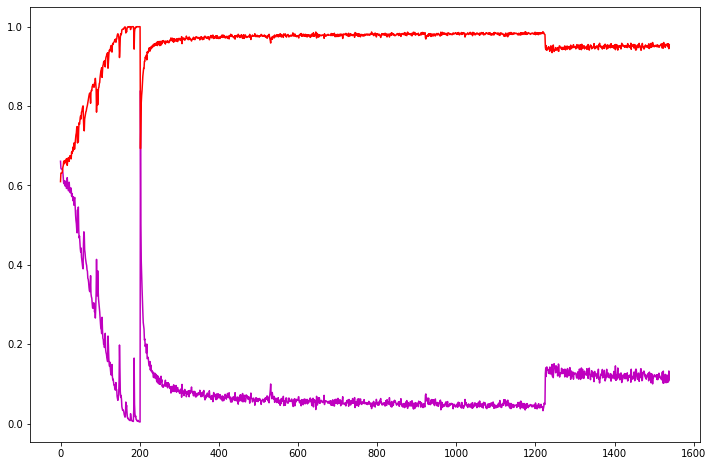

In [146]:
# Plot the Accuracy and Loss
x_values = np.array([i for i in range(len(train_metrics["loss"]))])
test_x_values = np.array([i for i in range(len(test_metrics["test_acc"]))])
fig = plt.gcf()
fig.set_size_inches(12, 8)
plt.plot()
colors = ['m', 'r', 'y', 'g', 'c', 'b', 'k']
for i, name in enumerate(train_metrics):
  print(colors[i], name)
  plt.plot(x_values, train_metrics[name], colors[i])
plt.plot(test_x_values*10, test_metrics["test_acc"], 'k')
print('k', "test_acc") 

## Testing

In [ ]:
# model = models.load_model('fldc_pi_36.h5')

In [64]:
# Evaluate the test accuracy

testBatchSize = 16
avgAcc = 0

model.reset_states()

# Generate the dataset for this epoch
x_test = np.zeros((testBatchSize, seqLength, 1))
y_test = np.zeros((testBatchSize, nBits))
frameCounter = -1
for x, y in lamps(seqLength, testBatchSize, testBatchSize, nBits, space, \
                  amtOcclude, amtBitNoise, amtPosNoise, maxSpeedPerFrame, encodingType, \
                  bFillNull, nullCoord, nullID, nullBit, bShuffle, bNormalizeInput):
    frameCounter += 1
    x_test[:,frameCounter,0] = x['on']
    if frameCounter == (seqLength-1):
        y_test = np.squeeze(y['bits'])

# Predict
startTime = time.time()
pred = model.predict(x_test, batch_size=testBatchSize)
stopTime = time.time()
pred_bits = np.squeeze((pred > 0.5).astype(int))
actual_bits = y_test.astype(int)

print("Printing incorrect predictions...")
for i in range(testBatchSize):
    if(np.any(pred_bits[i] != actual_bits[i])):
        print(pred[i], actual_bits[i])
print("...done in ", (stopTime-startTime)*1000, " ms")
    
#     if np.sum(pred_bits == y_test.astype(int)) / (nBits*testBatchSize)

# print(np.sum(pred_bits == y_test.astype(int)) / (nBits*testBatchSize)*100, "%")

#         pred_bits = np.squeeze((pred[0] > 0.5).astype(int))
#         acc = np.sum(np.array(pred_bits == y_test["bits"][0]).astype(int))/nBits
#         if acc > maxAcc: maxAcc = acc
#     #     acc = int(getID(pred_bits) == y_test["ids"][0])
# #         print(acc, "\t", pred_bits, y_test["bits"][0])

#     avgAcc += maxAcc / nTestBatches

# print(avgAcc)    

Printing incorrect predictions...
...done in  9.911298751831055  ms


In [ ]:
# for i in range(testBatchSize):
#     if(np.any(pred_bits[i] != actual_bits[i])):
#         print(pred[i], actual_bits[i])

## Train: Stage 2

Begins after 205 epochs of training at stage 1. Stage 1 trains with ideal data. After 205 epochs, a perfect 

In [136]:
# From 200 to 1200 epochs:
# amtOcclude = 0.03
# amtBitNoise = 0.03
# amtPosNoise = 0.02
# amtTimeShift = 0.01
# maxDelaySeen = seqLength - len(getRandomMaxEncoding(nBits)) # ?

# After 1200 epochs:
amtOcclude = 0.06
amtBitNoise = 0.06
amtPosNoise = 0.04
amtTimeShift = 0.02
maxDelaySeen = seqLength - len(getRandomMaxEncoding(nBits)) # ?

In [145]:
nEpochs = 10000

# Get all possible IDs
srcIDs = getAllPossibleMaxIDs(nBits)
# How many batches will we have?
nBatches = int(np.ceil(len(srcIDs) / batchSize))

# Train the network
print('Training...')
while epochCounter < nEpochs:
    epochCounter += 1

    # Shuffle the IDs
    np.random.shuffle(srcIDs)
    
    # Process this many batches
    train_metrics_epoch = {i:0 for i in model.metrics_names}
    for b in range(nBatches):
        
        # Roll the input
        srcIDs = np.roll(srcIDs, batchSize)
        
        # Get the training data
        x_train = np.zeros((batchSize, seqLength, 1))
        y_train = np.zeros((batchSize, nBits))
        frameCounter = -1
        for x, y in lamps(seqLength, nMinLamps, nMaxLamps, nBits, space, \
                          amtOcclude, amtBitNoise, amtPosNoise, maxSpeedPerFrame, encodingType, \
                          bFillNull, nullCoord, nullID, nullBit, bShuffle, bNormalizeInput, srcIDs, \
                          amtTimeShift, maxDelaySeen):
            frameCounter += 1
            x_train[:,frameCounter,0] = x['on']
            if frameCounter == (seqLength-1):
                y_train = np.squeeze(y['bits'])

        # Train for a single batch
        metrics_out = model.train_on_batch({'input_on':x_train}, \
                                           {'pred_bits':y_train})
        
        # Save the metrics from this batch
        for i, name in enumerate(model.metrics_names):
            train_metrics_epoch[name] += metrics_out[i]/nBatches
    
    # Save the metrics
    [train_metrics[name].append(train_metrics_epoch[name]) for i, name in enumerate(model.metrics_names)]
    
    print("Epoch ", epochCounter, ": ", train_metrics_epoch)
    
    if epochCounter % 50 == 0:
        model.save(modelName+'_'+str(epochCounter)+'.h5')
        with open(modelName+'_'+str(epochCounter)+'.pickle', 'wb') as handle:
            pickle.dump({"epochCounter":epochCounter, "train_metrics":train_metrics, "test_metrics":test_metrics}, handle, protocol=pickle.HIGHEST_PROTOCOL)

Training...
Epoch  1549 :  {'loss': 0.13242109842469982, 'acc': 0.9445533033075005}
Epoch  1550 :  {'loss': 0.11033974947600532, 'acc': 0.9541536148252155}


KeyboardInterrupt: 

In [138]:
# Evaluate the test accuracy

testBatchSize = 16
avgAcc = 0

model.reset_states()

# Generate the dataset for this epoch
x_test = np.zeros((testBatchSize, seqLength, 1))
y_test = np.zeros((testBatchSize, nBits))
frameCounter = -1
for x, y in lamps(seqLength, testBatchSize, testBatchSize, nBits, space, \
                  amtOcclude, amtBitNoise, amtPosNoise, maxSpeedPerFrame, encodingType, \
                  bFillNull, nullCoord, nullID, nullBit, bShuffle, bNormalizeInput, srcIDs, \
                  amtTimeShift, maxDelaySeen):
#     print(np.squeeze(x['on']))
    frameCounter += 1
    x_test[:,frameCounter,0] = x['on']
    if frameCounter == (seqLength-1):
        y_test = np.squeeze(y['bits'])

# Predict
startTime = time.time()
pred = model.predict(x_test, batch_size=testBatchSize)
stopTime = time.time()
pred_bits = np.squeeze((pred > 0.5).astype(int))
actual_bits = y_test.astype(int)

print("Printing incorrect predictions...")
for i in range(testBatchSize):
    if(np.any(pred_bits[i] != actual_bits[i])):
        print(i, pred_bits[i], actual_bits[i], x_test[i,:])
acc = np.sum(np.array(pred_bits == actual_bits).astype(int))/nBits
print(np.sum(pred_bits[i].flatten() == actual_bits[i].flatten())/(nBits*nMaxLamps))
print("...done in ", (stopTime-startTime)*1000, " ms")

Printing incorrect predictions...
3 [0 0 1 0 1 0 1 1 0 1 0] [0 1 1 0 1 0 1 1 0 1 0] [[-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [ 1.]
 [ 1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]
 [ 1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]
 [-1.]
 [-1.]
 [-1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]]
8 [0 1 1 1 1 1 1 1 

In [141]:
print(3, pred[3])
print(8, pred[8])
print(9, pred[9])
print(11, pred[11])
print(13, pred[13])
print(14, pred[14])


3 [0.10755342 0.31523427 0.9867189  0.06421721 0.9270673  0.26862627
 0.8303473  0.9043281  0.17348689 0.9368886  0.07642511]
8 [0.02401659 0.6739814  0.9911973  0.990751   0.72075206 0.5627047
 0.9879848  0.8236289  0.312106   0.6685177  0.91321373]
9 [0.02906543 0.987971   0.9754877  0.00933012 0.03660744 0.99404526
 0.3096003  0.04103822 0.6257087  0.8179925  0.07273287]
11 [0.99463296 0.00868016 0.98072267 0.01006117 0.99829906 0.01456037
 0.0054588  0.99753654 0.7280418  0.99438274 0.01076677]
13 [0.9998786  0.9982739  0.00507051 0.4562108  0.19277287 0.9982636
 0.7542348  0.00211701 0.03597087 0.99997437 0.99916977]
14 [6.7765319e-01 9.8587716e-01 1.6279221e-03 9.2653853e-01 9.9724030e-01
 7.7605546e-03 9.0358961e-01 9.6982253e-01 2.3571551e-03 9.9962586e-01
 1.6641617e-04]
